### Module Importing and Aliasing

In [71]:
# Data Analysis and Visualization
import pandas                as pd
import numpy                 as np
from   sklearn.preprocessing import MinMaxScaler
import talib # TA-Lib은 금융 시장 데이터의 기술적 분석을 수행하는데 필요한 멀티플랫폼 라이브러리 입니다.

# Visualization

from   matplotlib           import font_manager, rc
import matplotlib.pyplot    as plt
import seaborn              as sns
import mplfinance           as mpf # 주가데이터 가져오기
import plotly.graph_objects as go
import plotly.subplots      as ms

# Time Handling
import time
from   pytz     import timezone
from   datetime import date, datetime, timedelta

# HTTP Requests
from urllib.request import urlopen

# Data Sources
from   pykrx             import stock, bond
from pandas_datareader import data as pdr
import yfinance as yfin

# Configurations
import warnings

### Font settings

In [72]:
import matplotlib.font_manager as font_manager
import matplotlib as mpl
# Add every font at the specified location
font_dir = ['C:/python/fonts']
for font in font_manager.findSystemFonts(fontpaths=font_dir):
    print(mpl.font_manager.FontProperties(fname=font).get_name())
    font_manager.fontManager.addfont(font)
# Set font family globally
mpl.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False    # 마이너스 깨짐 방지
warnings.filterwarnings('ignore')             # 경고 무시
print(mpl.rcParams['font.family'])

Noto Serif Ahom
Black And White Picture
['NanumGothic']


### Configurations

### Day settings

In [73]:
# Date Strings
Yesterday             = datetime.strftime(datetime.now(timezone('Asia/Seoul')) - timedelta(1)  , "%Y-%m-%d") 
Previous_Business_Day = datetime.strftime(datetime.now(timezone('Asia/Seoul')) - timedelta(3)  , "%Y-%m-%d") if datetime.now(timezone('Asia/Seoul')).weekday() == 0 else YESTERDAY
Today                 = datetime.strftime(datetime.now(timezone('Asia/Seoul'))                 , "%Y-%m-%d") 
Tomorrow              = datetime.strftime(datetime.now(timezone('Asia/Seoul')) + timedelta(1)  , "%Y-%m-%d") 
Last_Year             = datetime.strftime(datetime.now(timezone('Asia/Seoul')) - timedelta(365), "%Y")     
Current_Year          = datetime.strftime(datetime.now(timezone('Asia/Seoul'))                 , "%Y")     

### General Functions

### Section: 세계 주요 지수의 등락율 비교

In [87]:
def get_world_index(ticker:str, startDt:str="2000-01-01", endDt:str=YESTERDAY):
    """
    세계 주요 주가 지수의 일별 OHCLV(Open, High, Close, Low, Volume) 데이터를 담은 DataFrame을 반환한다.
    [Parameters]
    ticker  (str) : 조회할 지수의 Ticker
    startDt (str) : 조회할 데이터의 시작 일자 (YYYYMMDD) (Default: "20000101")
    endDt   (str) : 조회할 데이터의 종료 일자 (YYYYMMDD) (Default: 전일)
    [Returns]
    pandas.core.frame.DataFrame : 세계 주요 주가 지수의 일별 OHCLV 데이터를 담은 DataFrame
    """
    startDt_datetime = datetime.strptime(startDt, '%Y-%m-%d')
    endDt_datetime   = datetime.strptime(endDt,   '%Y-%m-%d')
    return pdr.get_data_yahoo(ticker, startDt_datetime, endDt_datetime)
def get_normalization(df_ts):
    """
    시계열 데이터를 MinMaxScaler로 정규화한 결과를 반환한다.
    [Parameters]
    df_ts (pandas.core.frame.DataFrame) : 정규화할 시계열 데이터가 담긴 DataFrame
    [Returns]
    pandas.core.frame.DataFrame : 정규화된 시계열 데이터가 담긴 DataFrame
    """
    scaler = MinMaxScaler()
    scaler.fit(df_ts)
    return scaler.transform(df_ts)
def get_RSI(df_stock):
    """
    종목에 대한 DataFrame 형식의 OHLCV를 받아와 14일, 30일, 50일, 200일 RSI를 반환한다.
    [Parameters]
    df_stock (pandas.core.frame.DataFrame) : RSI를 계산할 데이터가 담긴 DataFrame
    [Returns]
    pandas.core.frame.DataFrame : RSI가 계산된 DataFrame
    """
    try:
        for n in [14, 30, 50, 200]:
            df_stock['RSI' + str(n)] = talib.RSI(df_stock['Close'].values, timeperiod = n)
    except:
        df_stock = df_stock.astype('float64')
        for n in [14, 30, 50, 200]:
            df_stock['RSI' + str(n)] = talib.RSI(df_stock['Close'].values, timeperiod = n)
    return df_stock
def get_RSI_OHLCV(df_stock):
    """
    종목에 대한 DataFrame 형식의 OHLCV를 받아와 14일 RSI를 반환한다.
    [Parameters]
    df_stock (pandas.core.frame.DataFrame) : RSI를 계산할 데이터가 담긴 DataFrame
    [Returns]
    pandas.core.frame.DataFrame : RSI가 계산된 DataFrame
    """
    df_stock = df_stock.astype('float64')
    df_stock['RSI14'] = talib.RSI(df_stock['종가'].values, timeperiod = 14)
    return df_stock
def preprocessing_rsi_backtesting(df_stock):
    """
    기존 전처리한 데이터로 RSI 수익률을 산출하여 반환한다.
    [Parameters]
    df_stock (pandas.core.frame.DataFrame) : RSI 수익률을 계산할 데이터가 담긴 DataFrame
    [Returns]
    pandas.core.frame.DataFrame : RSI 수익률이 계산된 DataFrame
    """
    df_stock = df_stock.set_index('date')
    # 매매신호 컬럼 생성
    df_stock.loc[df_stock['RSI14']<30,'매매신호'] = True # 1이면 매수신호
    df_stock.loc[df_stock['RSI14']>70,'매매신호'] = False # 0이면 매도신호
    # 일간수익률 컬럼 생성
    df_stock['일간수익률'] = df_stock['Close'].pct_change() + 1
    # 보유여부 컬럼 생성
    df_stock.loc[df_stock['매매신호'].shift(1) == True, '보유여부']=True # 1이면 현재 보유
    df_stock.loc[df_stock['매매신호'].shift(1) == False, '보유여부']=False # 0이면 현재 보유x
    df_stock['보유여부'].ffill(inplace=True)
    df_stock['보유여부'].fillna(False,inplace=True)
    # 보유수익률 컬럼 생성 - 보유하지 않은 날에는 원금을 그대로 유지하므로 해당 거래일의 수익률은 1로 지정.
    df_stock['보유수익률'] = df_stock.loc[df_stock['보유여부']==True,'일간수익률']
    df_stock['보유수익률'].fillna(1,inplace=True)
    # RSI 누적수익률 컬럼 생성
    df_stock['RSI수익률'] = df_stock['보유수익률'].cumprod()
    df_stock['단순보유수익률'] = df_stock['Close'] / df_stock.iloc[0,0]
    return df_stock
def preprocessing_rsi_backtesting_OHLCV(df_stock):
    """
    KRX API를 통해 새로 불러온 데이터로 RSI 수익률을 반환한다.
    [Parameters]
    df_stock (pandas.core.frame.DataFrame) : RSI 수익률을 계산할 데이터가 담긴 DataFrame
    [Returns]
    pandas.core.frame.DataFrame : RSI 수익률이 계산된 DataFrame
    """
    # 매매신호 컬럼 생성
    df_stock.loc[df_stock['RSI14']<30,'매매신호'] = True # 1이면 매수신호
    df_stock.loc[df_stock['RSI14']>70,'매매신호'] = False # 0이면 매도신호
    # 일간수익률 컬럼 생성
    df_stock['일간수익률'] = df_stock['종가'].pct_change() + 1
    # 보유여부 컬럼 생성
    df_stock.loc[df_stock['매매신호'].shift(1) == True, '보유여부']=True # 1이면 현재 보유
    df_stock.loc[df_stock['매매신호'].shift(1) == False, '보유여부']=False # 0이면 현재 보유x
    df_stock['보유여부'].ffill(inplace=True)
    df_stock['보유여부'].fillna(False,inplace=True)
    # 보유수익률 컬럼 생성 - 보유하지 않은 날에는 원금을 그대로 유지하므로 해당 거래일의 수익률은 1로 지정.
    df_stock['보유수익률'] = df_stock.loc[df_stock['보유여부']==True,'일간수익률']
    df_stock['보유수익률'].fillna(1,inplace=True)
    # RSI 누적수익률 컬럼 생성
    df_stock['RSI수익률'] = df_stock['보유수익률'].cumprod()
    df_stock['단순보유수익률'] = df_stock['종가'] / df_stock.iloc[0,0]
    return df_stock
def scale_rsi_backtesting(scale):
    """
    모든 종목들의 rsi 백테스팅 수익률을 반환한다.
    [Parameters]
    scale (str) : RSI 수익률을 계산할 인덱스 (코스피:'kospi' | 대형주:'large' | 중형주:'medium' | 소형주:'small')
    [Returns]
    pandas.core.series.Series : 규모별 각 종목의 RSI 수익률이 계산된 Series
    """
    yeild=[]
    start_time = time.time()
    # s 는 각 인덱스에 해당하는 종목
    for s in scale:
        _loop_start_time = time.time()
        df = stock.get_market_ohlcv('20200301','20221231', s)       # 2000년 3월1일부터 2022년 12월 31일까지의 정보들
        print(f"{s}: get_market_ohlcv 처리 완료, 소요 시간: {round(time.time() - _loop_start_time, 2)}s")
        df = get_RSI_OHLCV(df)                              # RSI 컬럼을 생성하는 함수 호출
        print(f"{s}: get_RSI_OHLCV2 처리 완료, 소요 시간: {round(time.time() - _loop_start_time, 2)}s")
        df = preprocessing_rsi_backtesting_OHLCV(df)        # RSI 수익률을 구하는 함수 호출
        print(f"{s}: preprocessing_rsi_backtesting_OHLCV2 처리 완료, 소요 시간: {round(time.time() - _loop_start_time, 2)}s")
        yeild.append(df.iloc[-1].loc['RSI수익률'])
    s = pd.Series(yeild)
    return s

In [77]:
# 지수들의 티커
ticker_list = []
for ticker in stock.get_index_ticker_list():
    ticker_list.append([ticker, stock.get_index_ticker_name(ticker)])

# 데이터 프레임 생성
scale_2022 = pd.DataFrame(ticker_list).iloc[:4,:]

# 열 명 변경
scale_2022.columns = ['ticker','name2022']

# DataFrame 구축

# DF 생성
df_scale_day = pd.DataFrame([])          # 일단위 데이터
df_scale_month = pd.DataFrame([])        # 월단위 데이터
df_scale_year = pd.DataFrame([])         # 년단위 데이터

# DF 내용 쓰기
for j in range(scale_2022.iloc[:,0].count()):
    # ticker 값을 i에 저장
    i = scale_2022.iloc[j,0]
    
    # temp DF에 2000.01.01~2022.12.31 규모별 ohlcv와 fundamental 쓰기(merge 이용하여 옆으로 붙임.)
    temp_day = pd.merge(stock.get_index_ohlcv("20030301", "20221231", str(i)).reset_index(), 
                     stock.get_index_fundamental("20030301", "20221231", str(i)).reset_index(), 
                     how='outer')
    temp_month = stock.get_index_ohlcv("20030301", "20221231", str(i),'m').reset_index()
                
    temp_year = stock.get_index_ohlcv("20030301", "20211231", str(i),'y').reset_index()
    
    # 해당 섹터 ticker, 섹터 명칭 쓰기
    temp_day['scale_name'] = stock.get_index_ticker_name(i)
    temp_day['scale_ticker'] = i
    
    temp_month['scale_name'] = stock.get_index_ticker_name(i)
    temp_month['scale_ticker'] = i
    
    temp_year['scale_name'] = stock.get_index_ticker_name(i)
    temp_year['scale_ticker'] = i
    
    # 임시 DF를 결과물 DF에 합치기
    df_scale_day = pd.concat([df_scale_day,temp_day])
    df_scale_month = pd.concat([df_scale_month,temp_month])
    df_scale_year = pd.concat([df_scale_year,temp_year])

# 칼럼명 영어로 변환
df_scale_day.columns = ['date','Open','High','Low','Close','Volume','Volume($)',
                     'Market_Cap','Change','PER','FWDPER','PBR','dividend_Yield','scale_name','scale_ticker']
df_scale_month.columns = ['date','Open','High','Low','Close','Volume','Volume($)','scale_name','scale_ticker']
df_scale_year.columns = ['date','Open','High','Low','Close','Volume','Volume($)','scale_name','scale_ticker']

# 일별 데이터를 규모별로 분리
df_scale_day_kospi = df_scale_day[df_scale_day['scale_name']=='코스피'] 
df_scale_day_small = df_scale_day[df_scale_day['scale_name']=='코스피 소형주']
df_scale_day_medium = df_scale_day[df_scale_day['scale_name']=='코스피 중형주']
df_scale_day_large = df_scale_day[df_scale_day['scale_name']=='코스피 대형주']

# 월별 데이터를 규모별로 분리
df_scale_month_kospi = df_scale_month[df_scale_month['scale_name']=='코스피']
df_scale_month_small = df_scale_month[df_scale_month['scale_name']=='코스피 소형주']
df_scale_month_medium = df_scale_month[df_scale_month['scale_name']=='코스피 중형주']
df_scale_month_large = df_scale_month[df_scale_month['scale_name']=='코스피 대형주']

# 연도별 데이터를 규모별로 분리
df_scale_year_kospi = df_scale_year[df_scale_year['scale_name']=='코스피']
df_scale_year_small = df_scale_year[df_scale_year['scale_name']=='코스피 소형주']
df_scale_year_medium = df_scale_year[df_scale_year['scale_name']=='코스피 중형주']
df_scale_year_large = df_scale_year[df_scale_year['scale_name']=='코스피 대형주']

df_scale_year_kospi_index = (df_scale_year_kospi['Close'] / df_scale_year_kospi['Close'][0]) * 100
df_scale_year_small_index = (df_scale_year_small['Close'] / df_scale_year_small['Close'][0]) * 100
df_scale_year_medium_index = (df_scale_year_medium['Close'] / df_scale_year_medium['Close'][0]) * 100
df_scale_year_large_index = (df_scale_year_large['Close'] / df_scale_year_large['Close'][0]) * 100

df_scale_month_kospi_index = (df_scale_month_kospi['Close'] / df_scale_month_kospi['Close'][0]) * 100
df_scale_month_small_index = (df_scale_month_small['Close'] / df_scale_month_small['Close'][0]) * 100
df_scale_month_medium_index = (df_scale_month_medium['Close'] / df_scale_month_medium['Close'][0]) * 100
df_scale_month_large_index = (df_scale_month_large['Close'] / df_scale_month_large['Close'][0]) * 100

df_scale_day_kospi_index = (df_scale_day_kospi['Close'] / df_scale_day_kospi['Close'][0]) * 100
df_scale_day_small_index = (df_scale_day_small['Close'] / df_scale_day_small['Close'][0]) * 100
df_scale_day_medium_index = (df_scale_day_medium['Close'] / df_scale_day_medium['Close'][0]) * 100
df_scale_day_large_index = (df_scale_day_large['Close'] / df_scale_day_large['Close'][0]) * 100

### Section: KOSPI와 KOSPI에 대한 RSI 14간 상관관계

In [78]:
# 일별 데이터 RSI(14) 컬럼 추가
df_scale_day_kospi = get_RSI(df_scale_day_kospi)
df_scale_day_large = get_RSI(df_scale_day_large)
df_scale_day_medium = get_RSI(df_scale_day_medium)
df_scale_day_small = get_RSI(df_scale_day_small)

# 월별 데이터 RSI(14) 컬럼 추가
df_scale_month_kospi = get_RSI(df_scale_month_kospi)
df_scale_month_large = get_RSI(df_scale_month_large)
df_scale_month_medium = get_RSI(df_scale_month_medium)
df_scale_month_small = get_RSI(df_scale_month_small)

# 년별 데이터 RSI(14) 컬럼 추가
df_scale_year_kospi = get_RSI(df_scale_year_kospi)
df_scale_year_large = get_RSI(df_scale_year_large)
df_scale_year_medium = get_RSI(df_scale_year_medium)
df_scale_year_small = get_RSI(df_scale_year_small)

df_scale_day_kospi_index = (df_scale_day_kospi['Close'] / df_scale_day_kospi['Close'][0]) * 100
df_scale_day_small_index = (df_scale_day_small['Close'] / df_scale_day_small['Close'][0]) * 100
df_scale_day_medium_index = (df_scale_day_medium['Close'] / df_scale_day_medium['Close'][0]) * 100
df_scale_day_large_index = (df_scale_day_large['Close'] / df_scale_day_large['Close'][0]) * 100

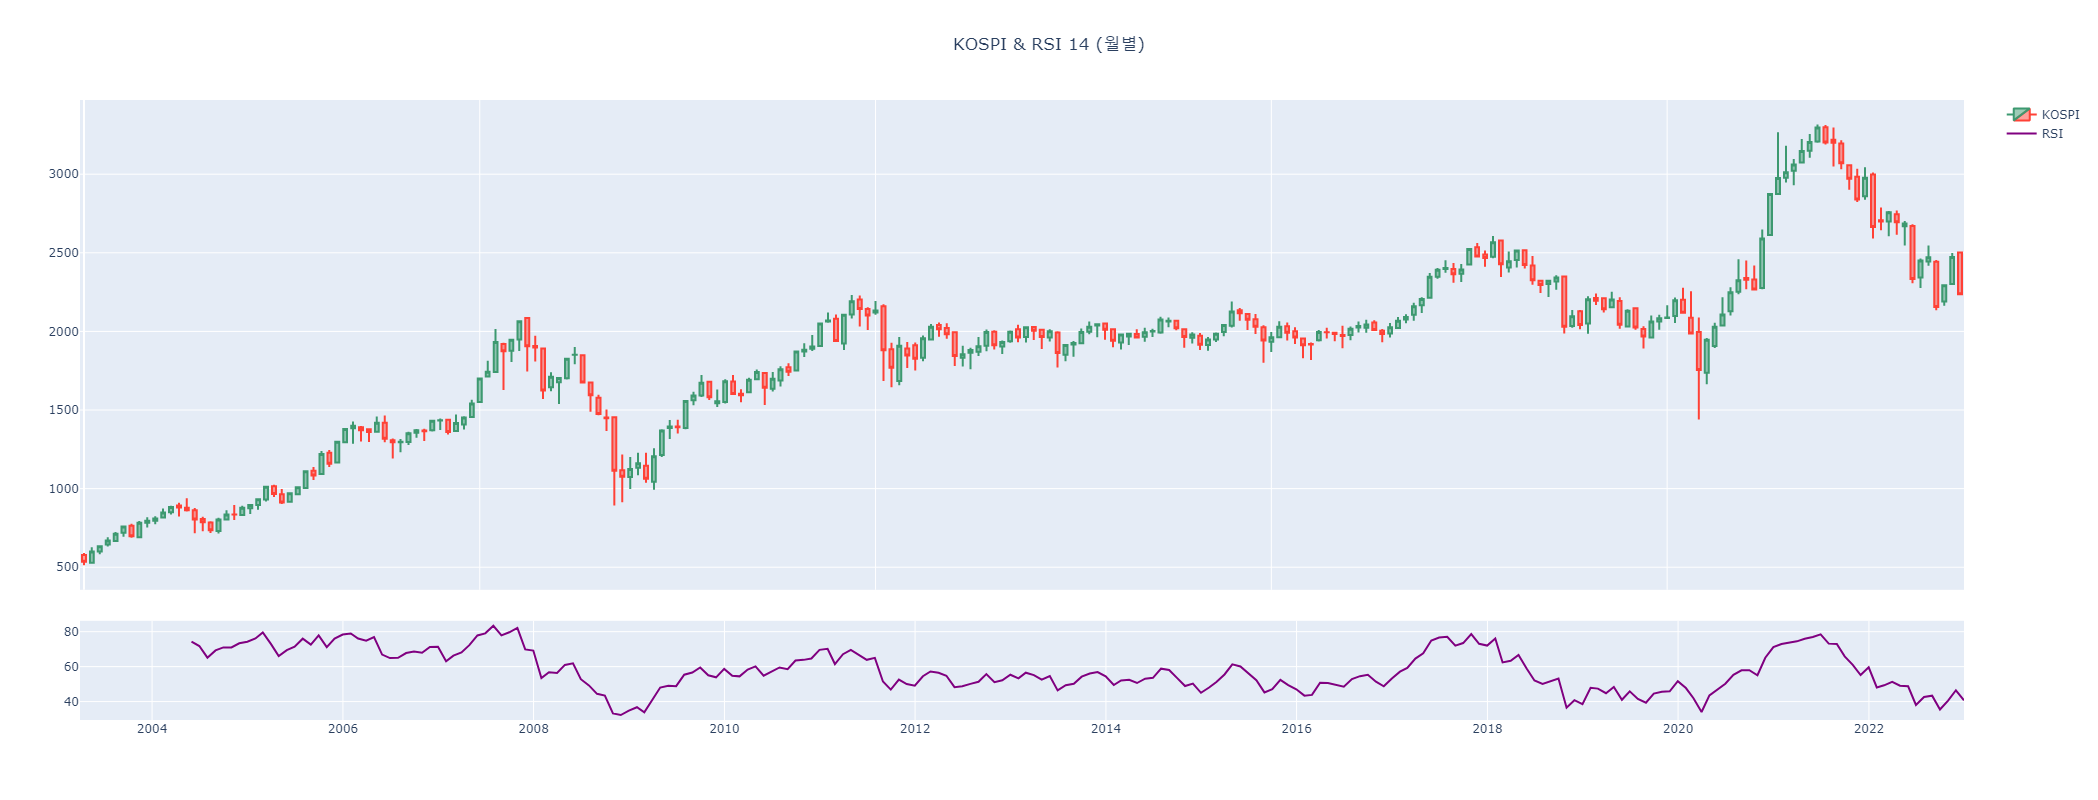

In [79]:
# Visualization: KOSPI & RSI 14 (Candle 차트, 월별)

plt.rcParams['font.family'] = 'Malgun Gothic' # 한글 폰트 설정 (맑은 고딕체)

candle = go.Candlestick(
x=df_scale_month_kospi.index,
open=df_scale_month_kospi['Open'],
high=df_scale_month_kospi['High'],
low=df_scale_month_kospi['Low'],
close=df_scale_month_kospi['Close'],
name='KOSPI')

RSI = go.Scatter(x=df_scale_month_kospi['date'], y=df_scale_month_kospi['RSI14'], line=dict(color='purple', width=2), name='RSI')

fig = ms.make_subplots(rows=5, cols=1, specs=[[{'rowspan':4}],[None],[None],[None],[{}]]
,shared_xaxes=True, horizontal_spacing=0.03, vertical_spacing=0.05)
fig.add_trace(candle,row=1,col=1)
fig.add_trace(RSI,row=5,col=1)
fig.update_layout(width=1000, height=800, xaxis_rangeslider_visible=False,title_text="KOSPI & RSI 14 (월별)", title_x=0.5)

fig.show()

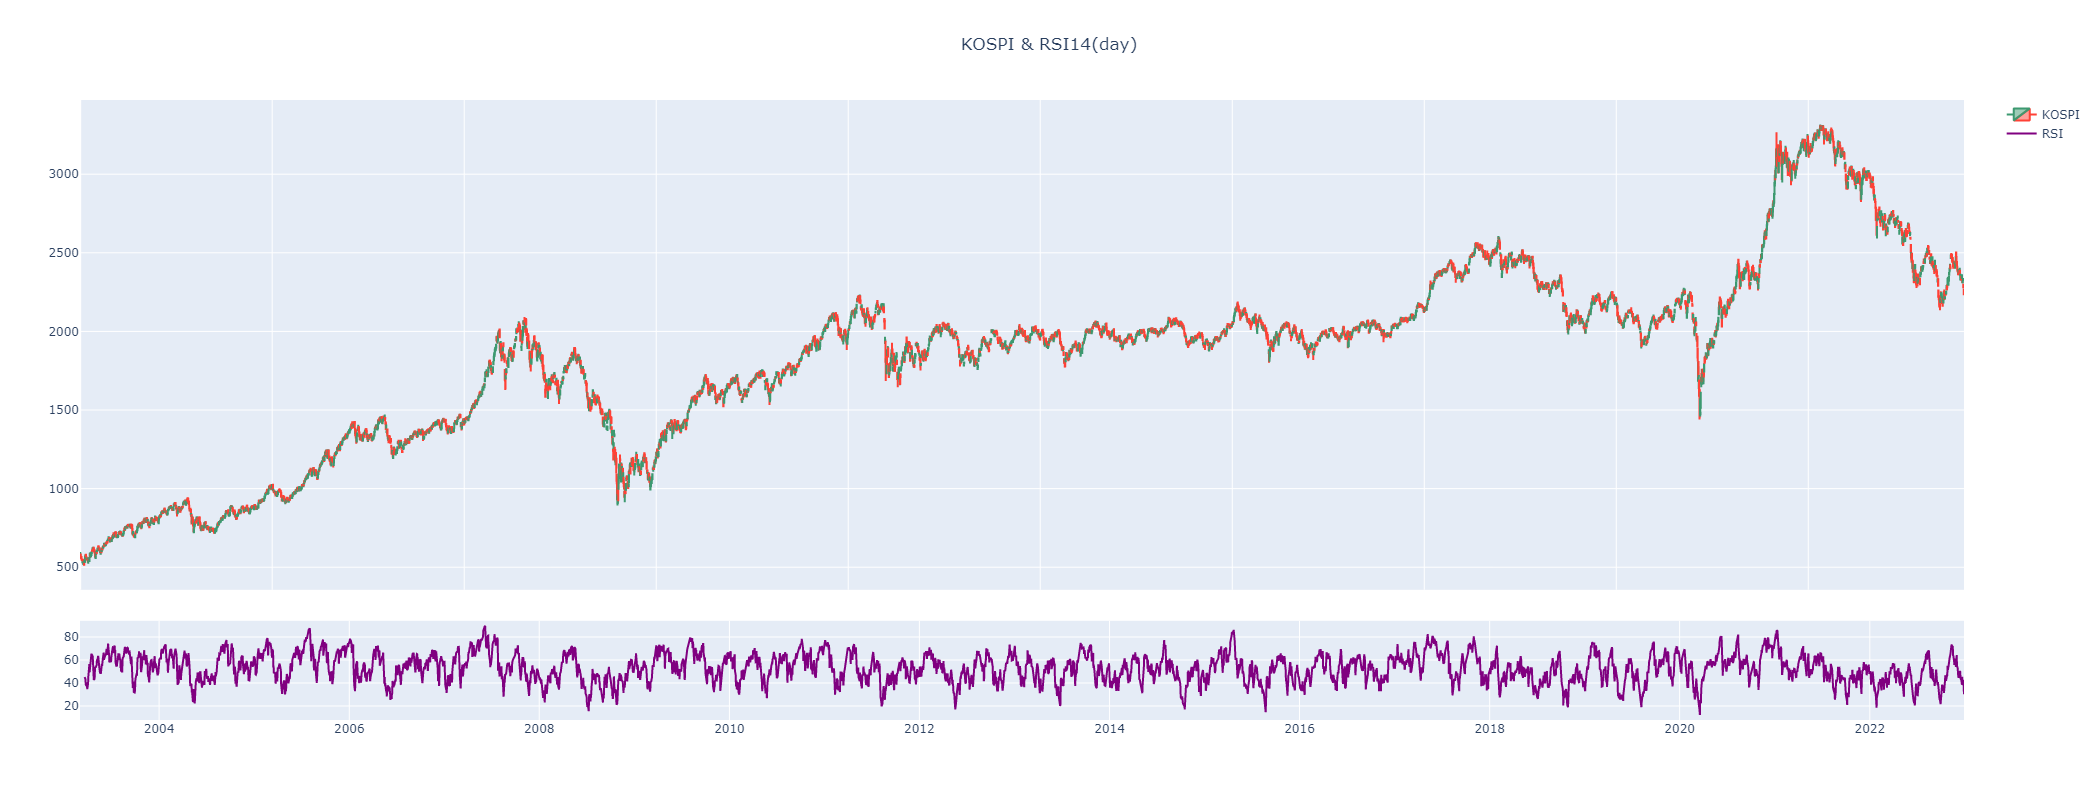

In [80]:
# Visualization: KOSPI & RSI 14 (Candle 차트, 일별)

candle = go.Candlestick(
x=df_scale_day_kospi.index,
open=df_scale_day_kospi['Open'],
high=df_scale_day_kospi['High'],
low=df_scale_day_kospi['Low'],
close=df_scale_day_kospi['Close'],
name='KOSPI')

RSI = go.Scatter(x=df_scale_day_kospi['date'], y=df_scale_day_kospi['RSI14'], line=dict(color='purple', width=2), name='RSI')

fig = ms.make_subplots(rows=5, cols=1, specs=[[{'rowspan':4}],[None],[None],[None],[{}]]
,shared_xaxes=True, horizontal_spacing=0.03, vertical_spacing=0.05)
fig.add_trace(candle,row=1,col=1)
fig.add_trace(RSI,row=5,col=1)
fig.update_layout(width=1000, height=800, xaxis_rangeslider_visible=False,title_text="KOSPI & RSI14(day)", title_x=0.5)

fig.show()

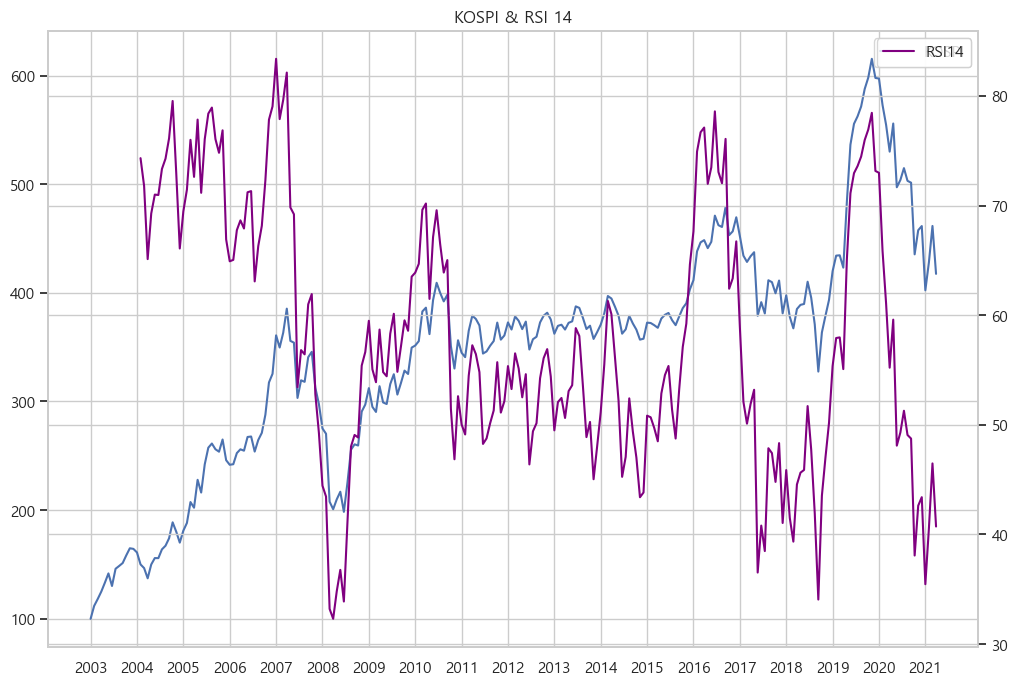

In [81]:
# Visualization: KOSPI & RSI 14

fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot()
ax1.plot(df_scale_month_kospi_index,label="KOSPI")
plt.legend()
color = 'purple'
ax2 = ax1.twinx()
ax2.plot(df_scale_month_kospi['RSI14'],label="RSI14",color=color)
plt.legend()

plt.xticks(list(i for i in range(0,240,13)),df_scale_year_kospi['date'].dt.year.unique())
plt.title("KOSPI & RSI 14")
plt.show()

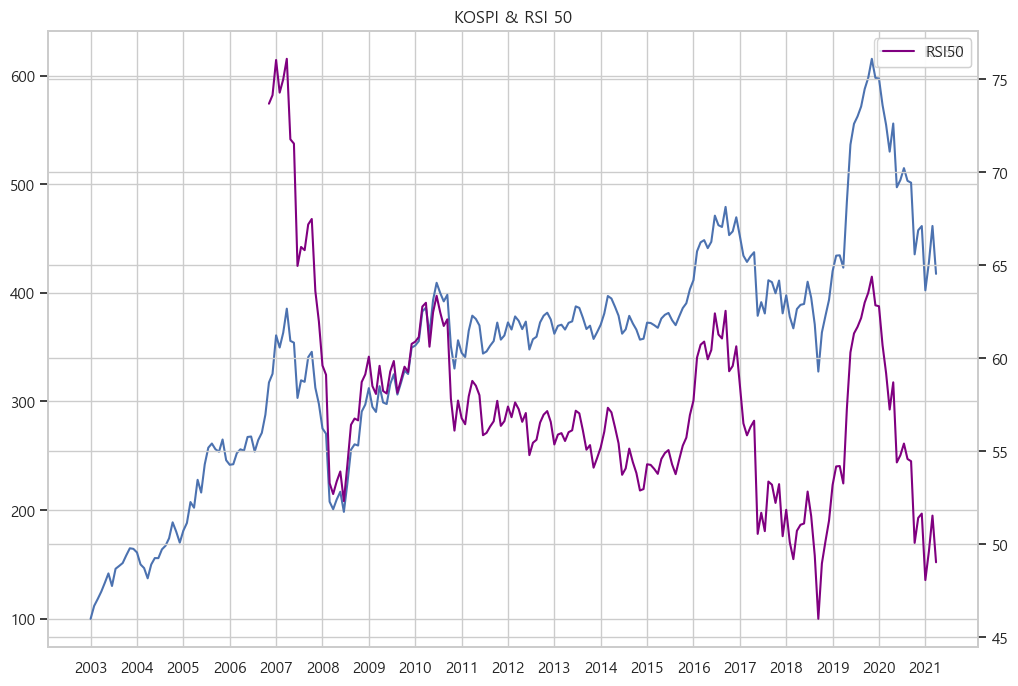

In [82]:
# Visualization: KOSPI & RSI 14

fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot()
ax1.plot(df_scale_month_kospi_index,label="KOSPI")
plt.legend()
color = 'purple'
ax2 = ax1.twinx()
ax2.plot(df_scale_month_kospi['RSI50'],label="RSI50",color=color)
plt.legend()

plt.xticks(list(i for i in range(0,240,13)),df_scale_year_kospi['date'].dt.year.unique())
plt.title("KOSPI & RSI 50")
plt.show()

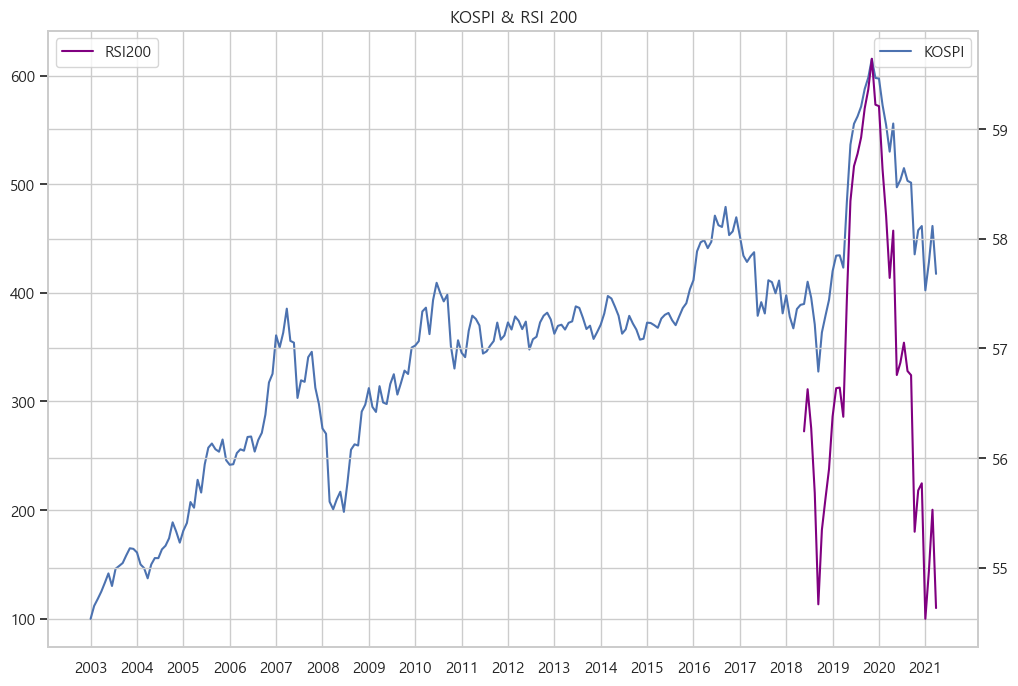

In [83]:
# Visualization: KOSPI & RSI 14

fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot()
ax1.plot(df_scale_month_kospi_index,label="KOSPI")
plt.legend()
color = 'purple'
ax2 = ax1.twinx()
ax2.plot(df_scale_month_kospi['RSI200'],label="RSI200",color=color)
plt.legend()

plt.xticks(list(i for i in range(0,240,13)),df_scale_year_kospi['date'].dt.year.unique())
plt.title("KOSPI & RSI 200")
plt.show()

In [84]:
# 코스피, 대형주, 중형주, 소형주에 해당하는 각 종목들 불러오기
large = stock.get_index_portfolio_deposit_file("1002") # 대형주
#large.remove('450140')
large

['005930',
 '373220',
 '000660',
 '207940',
 '006400',
 '051910',
 '005380',
 '035420',
 '035720',
 '000270',
 '005490',
 '068270',
 '105560',
 '028260',
 '055550',
 '012330',
 '003670',
 '066570',
 '096770',
 '034730',
 '086790',
 '323410',
 '032830',
 '003550',
 '033780',
 '015760',
 '051900',
 '009150',
 '011200',
 '010130',
 '017670',
 '034020',
 '036570',
 '329180',
 '010950',
 '018260',
 '000810',
 '316140',
 '030200',
 '009830',
 '090430',
 '259960',
 '003490',
 '377300',
 '024110',
 '352820',
 '011070',
 '086280',
 '011170',
 '302440',
 '009540',
 '383220',
 '000060',
 '326030',
 '138040',
 '251270',
 '097950',
 '361610',
 '402340',
 '028050',
 '010140',
 '088980',
 '018880',
 '034220',
 '035250',
 '032640',
 '267250',
 '047810',
 '271560',
 '005830',
 '161390',
 '004020',
 '012450',
 '011780',
 '006800',
 '000720',
 '021240',
 '008560',
 '000100',
 '078930',
 '011790',
 '241560',
 '002790',
 '029780',
 '071050',
 '128940',
 '004990',
 '307950',
 '028670',
 '282330',
 '010620',

In [85]:
Large = ['Samsung','LG에너지솔루션','SK하이닉스','삼성바이오로직스','동원산업','LG화학','현대차','Naver','KaKao','기아','Posco홀딩스','셀트리온','KB금융','삼성물산','신한지주','현대모비스','포스코케미칼','LG전자','SK이노베이션']

In [88]:
# 코스피 RSI 백테스팅 수익률에대한 통계치
kospi_stocks_yeild = scale_rsi_backtesting(large)
kospi_stocks_yeild

005930: get_market_ohlcv 처리 완료, 소요 시간: 1.1s
005930: get_RSI_OHLCV2 처리 완료, 소요 시간: 1.1s
005930: preprocessing_rsi_backtesting_OHLCV2 처리 완료, 소요 시간: 1.12s
373220: get_market_ohlcv 처리 완료, 소요 시간: 0.45s
373220: get_RSI_OHLCV2 처리 완료, 소요 시간: 0.46s
373220: preprocessing_rsi_backtesting_OHLCV2 처리 완료, 소요 시간: 0.46s
000660: get_market_ohlcv 처리 완료, 소요 시간: 1.01s
000660: get_RSI_OHLCV2 처리 완료, 소요 시간: 1.01s
000660: preprocessing_rsi_backtesting_OHLCV2 처리 완료, 소요 시간: 1.01s
207940: get_market_ohlcv 처리 완료, 소요 시간: 1.01s
207940: get_RSI_OHLCV2 처리 완료, 소요 시간: 1.01s
207940: preprocessing_rsi_backtesting_OHLCV2 처리 완료, 소요 시간: 1.01s
006400: get_market_ohlcv 처리 완료, 소요 시간: 1.07s
006400: get_RSI_OHLCV2 처리 완료, 소요 시간: 1.07s
006400: preprocessing_rsi_backtesting_OHLCV2 처리 완료, 소요 시간: 1.07s
051910: get_market_ohlcv 처리 완료, 소요 시간: 1.08s
051910: get_RSI_OHLCV2 처리 완료, 소요 시간: 1.08s
051910: preprocessing_rsi_backtesting_OHLCV2 처리 완료, 소요 시간: 1.08s
005380: get_market_ohlcv 처리 완료, 소요 시간: 1.02s
005380: get_RSI_OHLCV2 처리 완료, 소요 시간: 1.

0     1.007394
1     1.076216
2     1.019316
3     1.737675
4     1.421946
        ...   
95    2.664599
96    0.740360
97    0.651090
98    1.180664
99    1.763256
Length: 100, dtype: float64

In [89]:
kospi_stocks_yeild.index = large

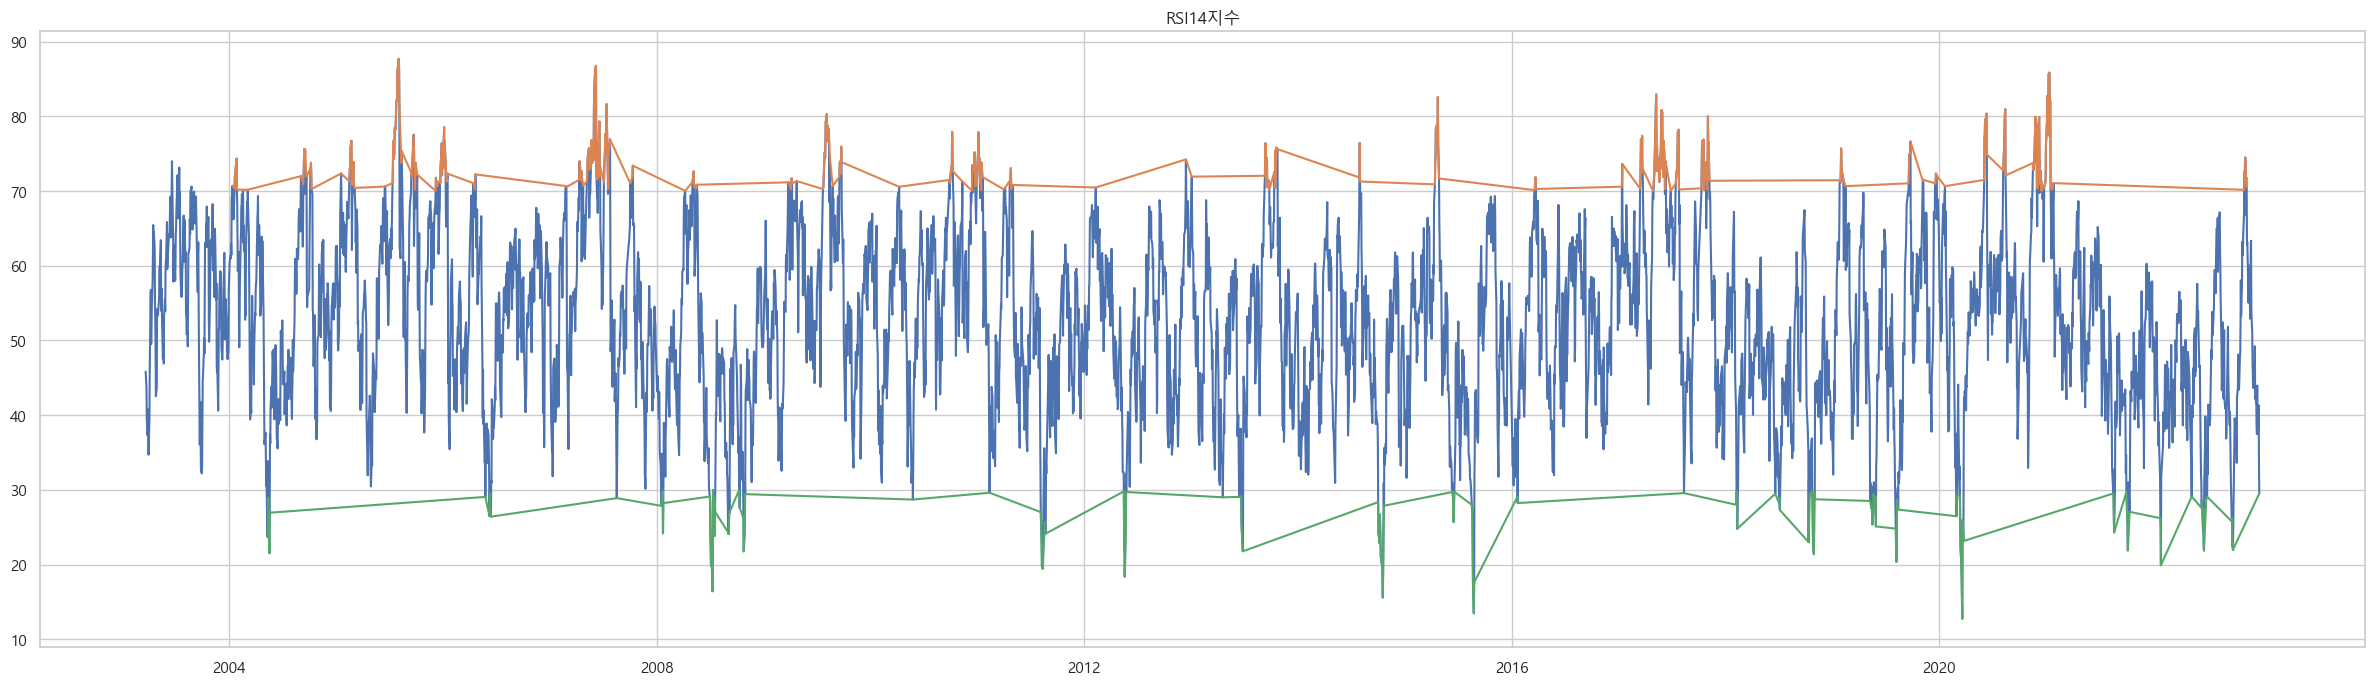

In [92]:
## 3개 데이터 분리

b_df = df_scale_day_large_rsi.dropna().query('RSI14 >= 70')
b_visits = b_df['RSI14']
 
c_df = df_scale_day_large_rsi.dropna().query('RSI14 <= 30')
c_visits = c_df['RSI14']

fig=plt.figure(figsize = (30,8))
fig.set_facecolor('white') ## 캔버스 색상 설정
ax = fig.add_subplot()
ax.plot(df_scale_day_large_rsi.RSI14.dropna().index,df_scale_day_large_rsi.RSI14.dropna()) ## 선그래프 생성
ax.plot(b_df.index,b_visits,label='매도신호') 
ax.plot(c_df.index,c_visits,label='매수신호')
plt.title('RSI14지수')
plt.show()

In [105]:
# 대형주들의 백테스팅을 통한 수익률 평균값 추출
large_yeild = kospi_stocks_yeild.describe().to_frame().T['mean'].values[0]
large_yeild

1.4951460587423488

In [546]:
df_scale_day_large_rsi['RSI수익률']

date
2003-03-03    1.000000
2003-03-04    1.000000
2003-03-05    1.000000
2003-03-06    1.000000
2003-03-07    1.000000
                ...   
2022-12-23    1.349144
2022-12-26    1.349144
2022-12-27    1.349144
2022-12-28    1.349144
2022-12-29    1.349144
Name: RSI수익률, Length: 4906, dtype: float64

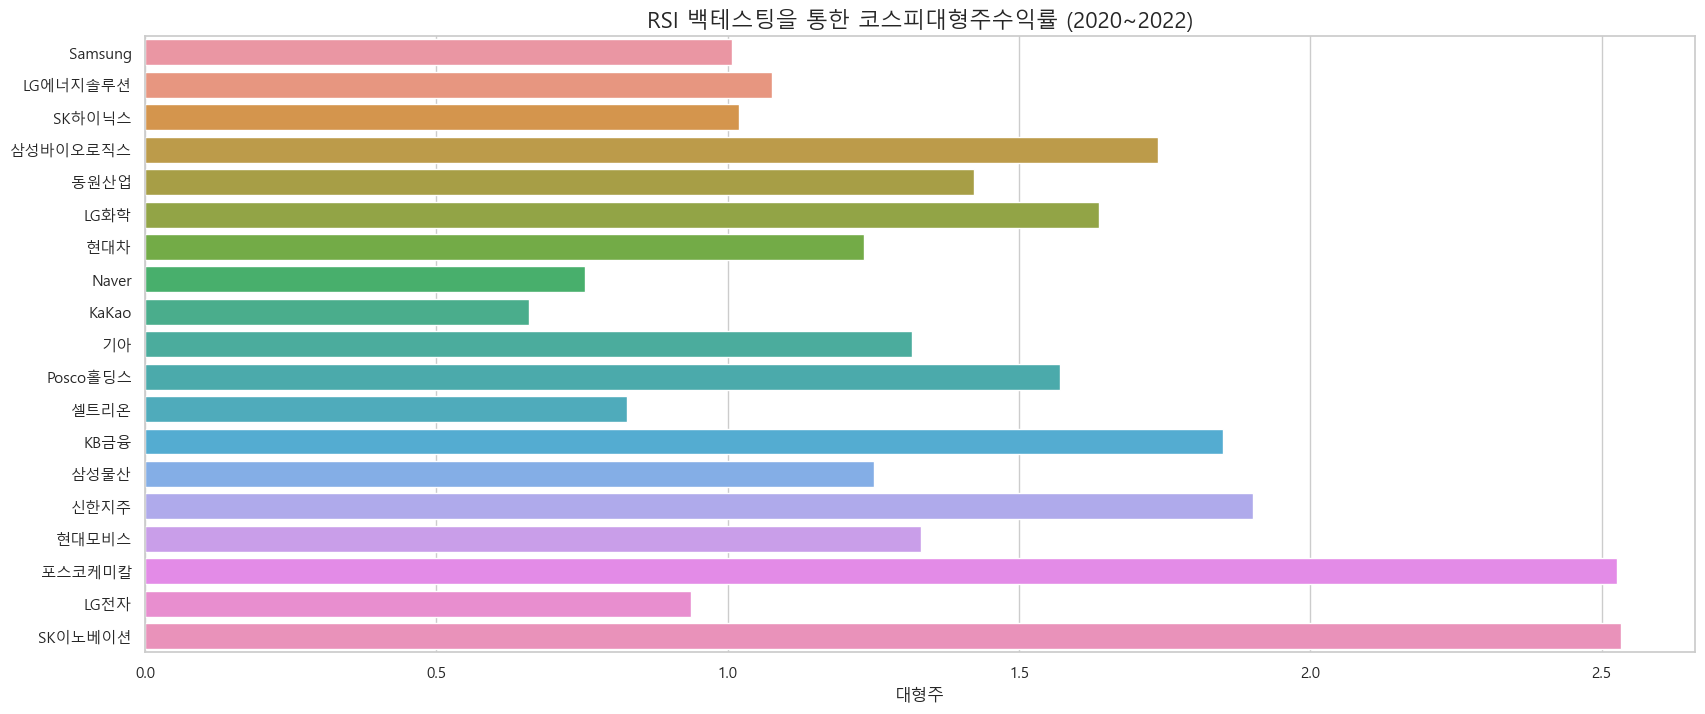

In [107]:
# Visualization: RSI 백테스팅을 통한 코스피,대형주,중형주,소형주 지수 수익률 (2003-2021)
fig = plt.figure(figsize=(20,8))
plt.title("RSI 백테스팅을 통한 코스피대형주수익률 (2020~2022)",size=16)
sns.barplot(kospi_stocks_yeild[:19],Large,label="Large-cap")
plt.xlabel('대형주')
plt.show()

### Section: 코스피 종목의 PER, PBR과 코스피 지수와의 연관성 분석
- 코로나 팬데믹이 시작된 2021년 12월 30일을 기준시점으로 선정하여 팬데믹으로 인한 세계 증시가 전체적으로 하락장에 들어섰다.
- 이러한 하락장 속에서도 PER과 PBR 상위 15개, 하위 15개 종목들의 주가가 띄는 경향성을 분석한다.

In [173]:
# Data Load
per_kospi = pd.read_csv('https://drive.google.com/uc?id=1UM6bCKmDWrDo5ROlMq990hfA9fTrgJAm', encoding='cp949') # 코스피 종목 
kospi_df = stock.get_index_fundamental("2000-01-01", "2022-12-31", "1001") # 코스피

# kospi 슬라이싱
kospi_short = kospi_df[['종가']]
kospi_short = kospi_short.reset_index(drop=False)
kospi_short.rename(columns={'날짜':'Date', '종가':'Close'}, inplace=True)
kospi_short = kospi_short[kospi_short['Date'] >= '2021-12-30']

# 코스피 종목
per_kospi = per_kospi[['종목코드', '종목명', 'PER', 'PBR']]
per_kospi = per_kospi[per_kospi['PER'].notnull()]

# PER PBR에 따라 상하위 종목 나누기
lowper_kospi = per_kospi.sort_values(by=['PER', 'PBR']).head(15)
highper_kospi = per_kospi.sort_values(by=['PER', 'PBR'], ascending=False).head(15)
lowpbr_kospi = per_kospi.sort_values(by=['PBR', 'PER']).head(15)
highpbr_kospi = per_kospi.sort_values(by=['PBR', 'PER'], ascending=False).head(15)
kospi_df = [lowper_kospi,highper_kospi,lowpbr_kospi,highpbr_kospi]
# 데이터프레임 생성 
name_list = ['lowper','highper','lowpbr','highpbr']
for i in name_list:
    globals()['df_{}'.format(i)] = pd.DataFrame()
df_list = [df_lowper,df_highper,df_lowpbr,df_highpbr]

In [174]:
# per,pbr 하위 상위 15개 종목의 코드들의 기간동안의 ohlcv를 데이터프레임으로 불러와 가공
j = 0
for i in kospi_df:
    for ticker in list(i['종목코드']):
        df = stock.get_market_ohlcv_by_date(fromdate="2021-12-30", todate="2022-12-31", ticker=ticker)
        df = df.assign(종목코드=ticker, 종목명=stock.get_market_ticker_name(ticker)) # 새 컬럼 할당
        if j == 0:
            df_lowper = pd.concat([df_lowper, df], axis=0)
        elif j == 1:
            df_highper = pd.concat([df_highper,df], axis=0)
        elif j == 2:
            df_lowpbr = pd.concat([df_lowpbr, df], axis=0)
        elif j == 3:
            df_highpbr = pd.concat([df_highpbr,df],axis=0)
    j = j + 1
df_lowper

시가     고가     저가     종가     거래량        거래대금   등락률    종목코드   종목명
날짜                                                                            
2021-12-30  10400  10700  10350  10500   94685   996346000  0.96  009410  태영건설
2022-01-03  10450  10550  10400  10450   42058   439167050 -0.48  009410  태영건설
2022-01-04  10450  10500  10200  10500   81010   842545350  0.48  009410  태영건설
2022-01-05  10550  10750  10500  10650   84260   895429100  1.43  009410  태영건설
2022-01-06  10450  11050  10450  10750  132768  1435620700  0.94  009410  태영건설
...           ...    ...    ...    ...     ...         ...   ...     ...   ...
2022-12-23  22700  22700  22400  22550   20407   459863500 -1.53  002020   코오롱
2022-12-26  22550  22950  22450  22800   16448   373069600  1.11  002020   코오롱
2022-12-27  22600  23000  22600  23000   26156   599193850  0.88  002020   코오롱
2022-12-28  22700  22800  21600  22700   25359   570568850 -1.30  002020   코오롱
2022-12-29  22450  22550  21700  21900   35301   776785100 -3.52  002020   코오롱

[3705 rows x 9 columns]

In [175]:
df_lowper.reset_index(inplace=True)
df_lowper.rename(columns={'날짜':'Date','종가':'Close'},inplace=True)
df_highper.reset_index(inplace=True)
df_highper.rename(columns={'날짜':'Date','종가':'Close'},inplace=True)
df_lowpbr.reset_index(inplace=True)
df_lowpbr.rename(columns={'날짜':'Date','종가':'Close'},inplace=True)
df_highpbr.reset_index(inplace=True)
df_highpbr.rename(columns={'날짜':'Date','종가':'Close'},inplace=True)

In [176]:
# 코스피 보유수익률 계산
kospi_yeild = pd.DataFrame(kospi_short['Close']/kospi_short.iloc[0, 1]) # 첫 날 kospi가격으로 나누어서 수익률 계산 후 합침.
kospi_yeild = pd.concat([kospi_short[['Date']], kospi_yeild], axis=1)

In [178]:
# 종목별 보유수익률 계산
lowper_list = list(df_lowper['종목명'].unique())
highper_list = list(df_highper['종목명'].unique())
lowpbr_list = list(df_lowpbr['종목명'].unique())
highpbr_list = list(df_highpbr['종목명'].unique())

In [180]:
#for i in name_list:
#    globals()['{}_yeild'.format(i)] = pd.DataFrame()
lowper_yeild = pd.DataFrame()
for name in lowper_list:
    temp = df_lowper[df_lowper['종목명'] == name][['Date', 'Close']]
    temp = pd.DataFrame(temp['Close']/temp.iloc[0, 1])
    temp = temp.assign(종목명=name, Date=df_lowper['Date'])
    lowper_yeild = pd.concat([lowper_yeild, temp], axis=0)

highper_yeild = pd.DataFrame()
for name in highper_list:
    temp = df_highper[df_highper['종목명'] == name][['Date', 'Close']]
    temp = pd.DataFrame(temp['Close']/temp.iloc[0, 1])
    temp = temp.assign(종목명=name, Date=df_highper['Date'])
    highper_yeild = pd.concat([highper_yeild, temp], axis=0)
    
lowpbr_yeild = pd.DataFrame()
for name in lowpbr_list:
    temp = df_lowpbr[df_lowpbr['종목명'] == name][['Date', 'Close']]
    temp = pd.DataFrame(temp['Close']/temp.iloc[0, 1])
    temp = temp.assign(종목명=name, Date=df_lowpbr['Date'])
    lowpbr_yeild = pd.concat([lowpbr_yeild, temp], axis=0)
    
highpbr_yeild = pd.DataFrame()
for name in highpbr_list:
    temp = df_highpbr[df_highpbr['종목명'] == name][['Date', 'Close']]
    temp = pd.DataFrame(temp['Close']/temp.iloc[0, 1])
    temp = temp.assign(종목명=name, Date=df_highpbr['Date'])
    highpbr_yeild = pd.concat([highpbr_yeild, temp], axis=0)

Index([], dtype='object')

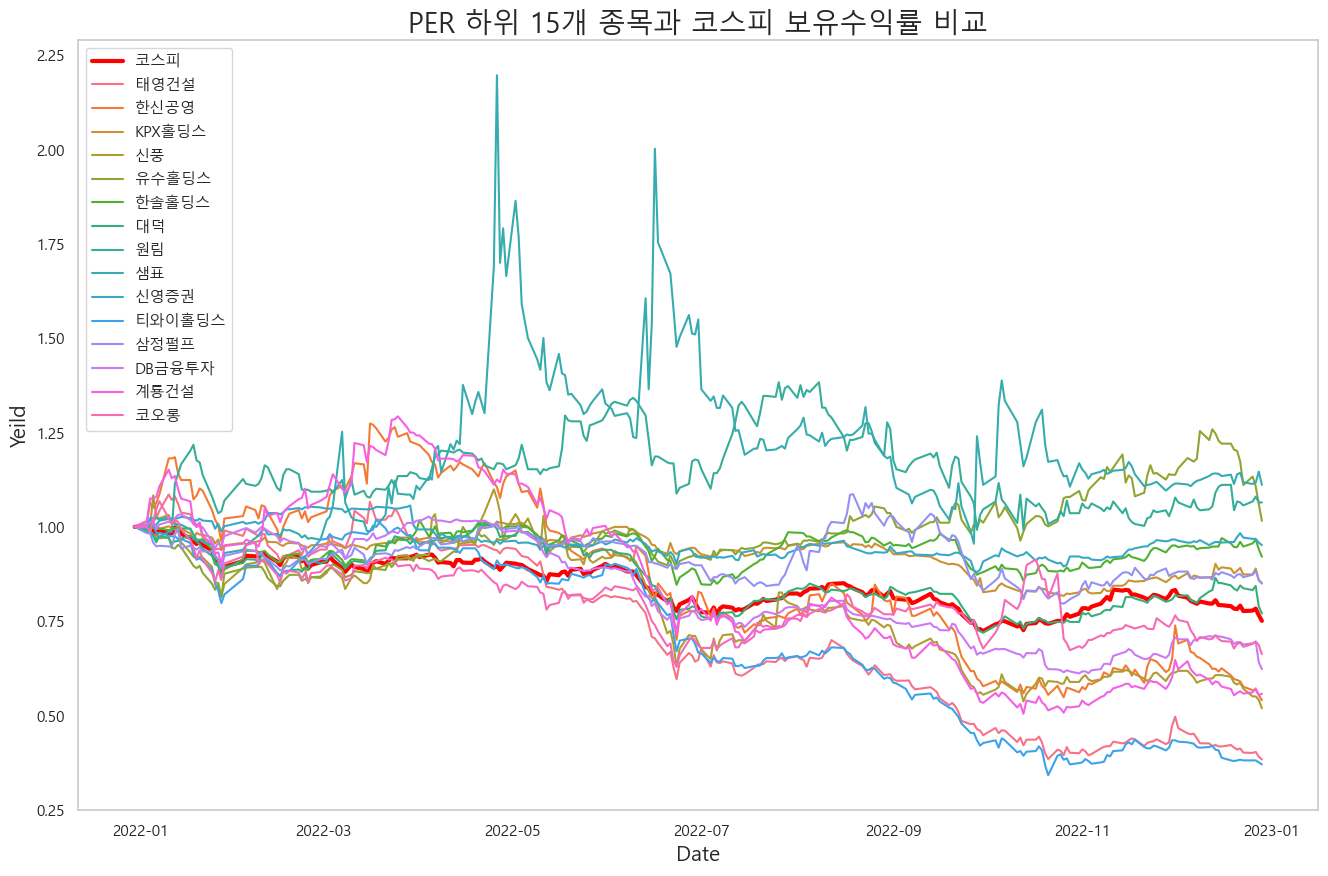

In [182]:
# Visualization: PER 하위 15개 종목과 코스피 보유수익률 비교

fig = plt.figure( figsize=(16, 10)) # 그래프 크기 조절

ax1 = sns.lineplot(
    data=kospi_yeild,
    x = 'Date',
    y = 'Close',
    label = '코스피',
    color = 'red',
    linewidth = 3
)

ax2 = sns.lineplot(
    data=lowper_yeild,
    x = 'Date',
    y = 'Close',
    hue = '종목명'
)

plt.legend(loc = 'best')
plt.ylabel('Yeild', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.grid()

plt.title('PER 하위 15개 종목과 코스피 보유수익률 비교', fontsize=20)
plt.show()


## 코스피 보유 수익률보다 높은 수익률을 보이는 종목들이 다량 확인되었다.
- 일부 종목에서는 순간적인 주가 급등 현상도 있었음이 확인되었다.
- 따라서 하락장에서도 저 PER 종목을 종목 선정에 있어서 하나의 기준으로 삼아도 된다고 볼 수 있다.

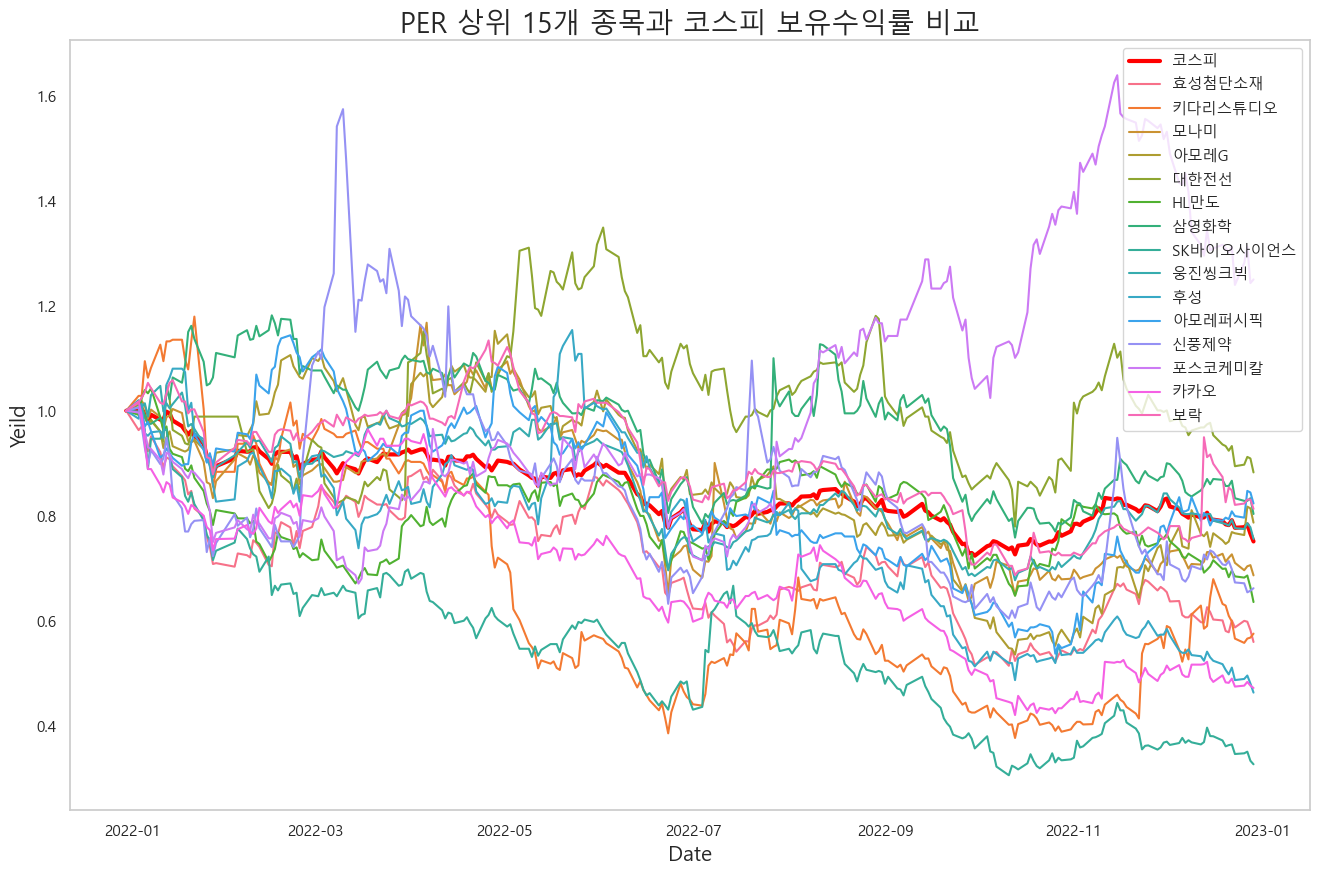

In [183]:
# Visualization: PER 상위 15개 종목과 코스피 보유수익률 비교

fig = plt.figure( figsize=(16, 10)) # 그래프 크기 조절

ax1 = sns.lineplot(
    data=kospi_yeild,
    x = 'Date',
    y = 'Close',
    label = '코스피',
    color = 'red',
    linewidth = 3
)

ax2 = sns.lineplot(
    data=highper_yeild,
    x = 'Date',
    y = 'Close',
    hue = '종목명'
)

plt.legend(loc = 'best')
plt.ylabel('Yeild', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.grid()

plt.title('PER 상위 15개 종목과 코스피 보유수익률 비교', fontsize=20)
plt.show()


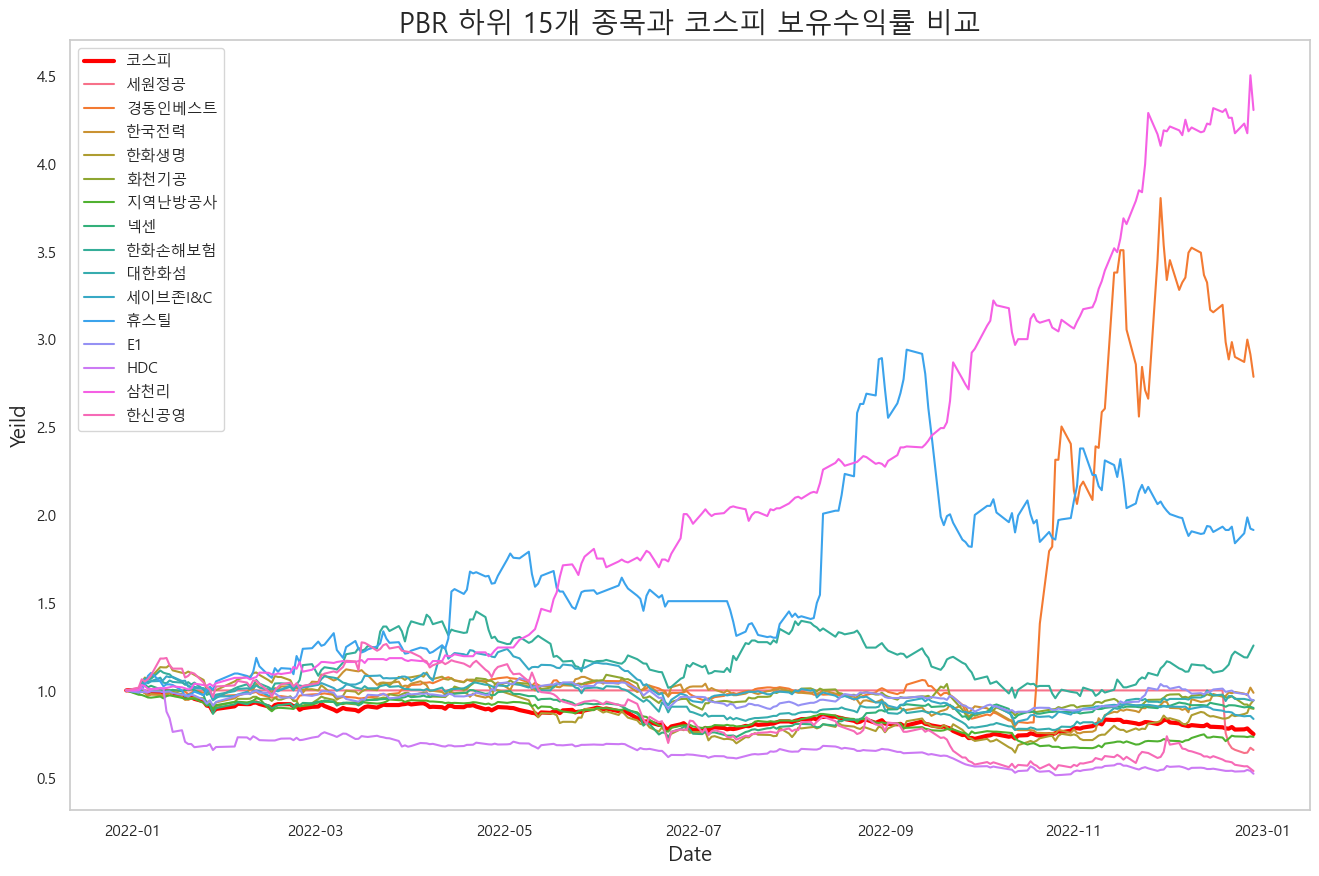

In [184]:
# Visualization: PBR 하위 15개 종목과 코스피 보유수익률 비교

fig = plt.figure( figsize=(16, 10)) # 그래프 크기 조절

ax1 = sns.lineplot(
    data=kospi_yeild,
    x = 'Date',
    y = 'Close',
    label = '코스피',
    color = 'red',
    linewidth = 3
)

ax2 = sns.lineplot(
    data=lowpbr_yeild,
    x = 'Date',
    y = 'Close',
    hue = '종목명'
)

plt.legend(loc = 'best')
plt.ylabel('Yeild', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.grid()

plt.title('PBR 하위 15개 종목과 코스피 보유수익률 비교', fontsize=20)
plt.show()

## PER 하위 15개 종목들과 마찬가지로 코스피 보유 수익률보다 높은 수익률을 보이는 종목들이 다량 확인되었다.
- 일부 종목에서는 PER 하위 15개 종목에서는 볼 수 없는 폭발적인 주가 급등 경향성을 보였다.
- 따라서 하락장에서도 PBR 하위 15개 종목들은 투자 대상으로 매력이 있다 판단된다.

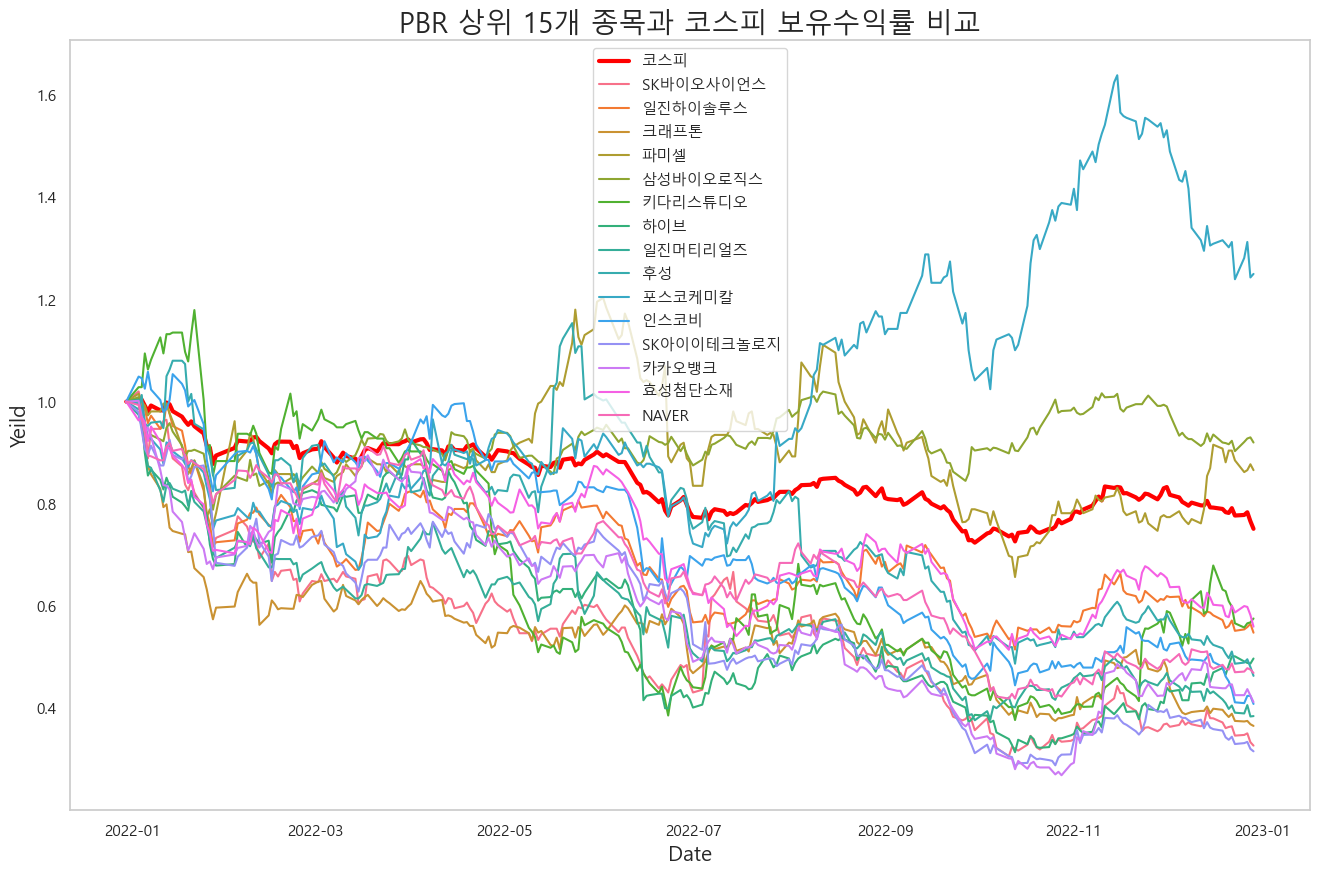

In [185]:
# Visualization: PBR 상위 15개 종목과 코스피 보유수익률 비교

fig = plt.figure( figsize=(16, 10)) # 그래프 크기 조절

ax1 = sns.lineplot(
    data=kospi_yeild,
    x = 'Date',
    y = 'Close',
    label = '코스피',
    color = 'red',
    linewidth = 3
)

ax2 = sns.lineplot(
    data=highpbr_yeild,
    x = 'Date',
    y = 'Close',
    hue = '종목명'
)

plt.legend(loc = 'best')
plt.ylabel('Yeild', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.grid()

plt.title('PBR 상위 15개 종목과 코스피 보유수익률 비교', fontsize=20)
plt.show()


## PER 하위 15개 종목들과 같이, 일부 종목에 있어선 코스피 보유 수익률보다 높은 수익률이 확인되었다.
- 하지만 낮은 수익률을 보이는 종목들이 PER 하위 15개 종목들과 비교하여 훨씬 더 많고
- 주가 하락 비율도 큰 것을 확인할 수 있었다.
- 따라서 PBR 상위 15개 종목들은 종목 선정 기준으로 부적합하다 판단된다.

### Section: 코스피 지수의 추이와 암호화폐 시장 지수의 상관성 비교 분석
- 암호화폐와 주식 시장은 비슷해 보이지만 다른 시장이다.
- 이를 한 번 알아보고자 두 데이터를 가져와 관계를 나타내보고자 한다.

In [197]:
'''
# kospi 슬라이싱
kospi_short = kospi_df[['종가']]
kospi_short = kospi_short.reset_index(drop=False)
kospi_short.rename(columns={'날짜':'Date', '종가':'Close'}, inplace=True)
kospi_short = kospi_short[kospi_short['Date'] >= '2021-12-30']
'''
kospi_short

Date    Close
5431 2021-12-30  2977.65
5432 2022-01-03  2988.77
5433 2022-01-04  2989.24
5434 2022-01-05  2953.97
5435 2022-01-06  2920.53
...         ...      ...
5673 2022-12-23  2313.69
5674 2022-12-26  2317.14
5675 2022-12-27  2332.79
5676 2022-12-28  2280.45
5677 2022-12-29  2236.40

[247 rows x 2 columns]

In [199]:
import pyupbit
print(pyupbit.get_tickers()) # 종목

['KRW-BTC', 'KRW-ETH', 'BTC-ETH', 'BTC-XRP', 'BTC-ETC', 'BTC-OMG', 'BTC-CVC', 'BTC-DGB', 'BTC-SC', 'BTC-SNT', 'BTC-WAVES', 'BTC-NMR', 'BTC-XEM', 'BTC-QTUM', 'BTC-BAT', 'BTC-LSK', 'BTC-STEEM', 'BTC-DOGE', 'BTC-BNT', 'BTC-XLM', 'BTC-ARDR', 'BTC-ARK', 'BTC-STORJ', 'BTC-GRS', 'BTC-REP', 'BTC-RLC', 'USDT-BTC', 'USDT-ETH', 'USDT-XRP', 'USDT-ETC', 'KRW-NEO', 'KRW-MTL', 'KRW-XRP', 'KRW-ETC', 'KRW-OMG', 'KRW-SNT', 'KRW-WAVES', 'KRW-XEM', 'KRW-QTUM', 'KRW-LSK', 'KRW-STEEM', 'KRW-XLM', 'KRW-ARDR', 'KRW-ARK', 'KRW-STORJ', 'KRW-GRS', 'KRW-REP', 'KRW-ADA', 'BTC-ADA', 'BTC-MANA', 'USDT-OMG', 'KRW-SBD', 'BTC-SBD', 'KRW-POWR', 'BTC-POWR', 'KRW-BTG', 'USDT-ADA', 'BTC-DNT', 'BTC-ZRX', 'BTC-TRX', 'BTC-TUSD', 'BTC-LRC', 'KRW-ICX', 'KRW-EOS', 'USDT-TUSD', 'KRW-TRX', 'BTC-POLYX', 'USDT-SC', 'USDT-TRX', 'KRW-SC', 'KRW-ONT', 'KRW-ZIL', 'KRW-POLYX', 'KRW-ZRX', 'KRW-LOOM', 'BTC-BCH', 'USDT-BCH', 'KRW-BCH', 'BTC-HIFI', 'BTC-LOOM', 'KRW-BAT', 'KRW-IOST', 'BTC-RFR', 'KRW-RFR', 'USDT-DGB', 'KRW-CVC', 'KRW-IQ', 'KRW-

In [208]:
tickers = [ _ for _ in pyupbit.get_tickers() if 'KRW' in _]
tickers

['KRW-BTC',
 'KRW-ETH',
 'KRW-NEO',
 'KRW-MTL',
 'KRW-XRP',
 'KRW-ETC',
 'KRW-OMG',
 'KRW-SNT',
 'KRW-WAVES',
 'KRW-XEM',
 'KRW-QTUM',
 'KRW-LSK',
 'KRW-STEEM',
 'KRW-XLM',
 'KRW-ARDR',
 'KRW-ARK',
 'KRW-STORJ',
 'KRW-GRS',
 'KRW-REP',
 'KRW-ADA',
 'KRW-SBD',
 'KRW-POWR',
 'KRW-BTG',
 'KRW-ICX',
 'KRW-EOS',
 'KRW-TRX',
 'KRW-SC',
 'KRW-ONT',
 'KRW-ZIL',
 'KRW-POLYX',
 'KRW-ZRX',
 'KRW-LOOM',
 'KRW-BCH',
 'KRW-BAT',
 'KRW-IOST',
 'KRW-RFR',
 'KRW-CVC',
 'KRW-IQ',
 'KRW-IOTA',
 'KRW-HIFI',
 'KRW-ONG',
 'KRW-GAS',
 'KRW-UPP',
 'KRW-ELF',
 'KRW-KNC',
 'KRW-BSV',
 'KRW-THETA',
 'KRW-QKC',
 'KRW-BTT',
 'KRW-MOC',
 'KRW-ENJ',
 'KRW-TFUEL',
 'KRW-MANA',
 'KRW-ANKR',
 'KRW-AERGO',
 'KRW-ATOM',
 'KRW-TT',
 'KRW-CRE',
 'KRW-MBL',
 'KRW-WAXP',
 'KRW-HBAR',
 'KRW-MED',
 'KRW-MLK',
 'KRW-STPT',
 'KRW-ORBS',
 'KRW-VET',
 'KRW-CHZ',
 'KRW-STMX',
 'KRW-DKA',
 'KRW-HIVE',
 'KRW-KAVA',
 'KRW-AHT',
 'KRW-LINK',
 'KRW-XTZ',
 'KRW-BORA',
 'KRW-JST',
 'KRW-CRO',
 'KRW-TON',
 'KRW-SXP',
 'KRW-HUNT',
 'KRW-PLA

In [307]:
import requests
days = 365 # 최근 n일의 데이터 수집 
idx =  'UBMI' # 인덱스명 
url = 'https://crix-api-cdn.upbit.com/v1/crix/candles/days?code=IDX.UPBIT.' + idx + '&count=' + str(days)
response = requests.get(url)
data = requests.get(url).json()
ubmi = pd.DataFrame(data)
ubmi

candleDateTime          candleDateTimeKst  openingPrice  \
0    2023-02-01T00:00:00+00:00  2023-02-01T09:00:00+09:00   5135.580820   
1    2023-01-31T00:00:00+00:00  2023-01-31T09:00:00+09:00   5062.364056   
2    2023-01-30T00:00:00+00:00  2023-01-30T09:00:00+09:00   5268.382494   
3    2023-01-29T00:00:00+00:00  2023-01-29T09:00:00+09:00   5140.824563   
4    2023-01-28T00:00:00+00:00  2023-01-28T09:00:00+09:00   5150.473983   
..                         ...                        ...           ...   
360  2022-02-06T00:00:00+00:00  2022-02-06T09:00:00+09:00   9488.534069   
361  2022-02-05T00:00:00+00:00  2022-02-05T09:00:00+09:00   9393.887690   
362  2022-02-04T00:00:00+00:00  2022-02-04T09:00:00+09:00   8557.996480   
363  2022-02-03T00:00:00+00:00  2022-02-03T09:00:00+09:00   8501.140024   
364  2022-02-02T00:00:00+00:00  2022-02-02T09:00:00+09:00   8912.336580   

       highPrice     lowPrice   tradePrice  candleAccTradeVolume  \
0    5142.120501  5082.411662  5083.912789                   0.0   
1    5161.536025  5013.928529  5134.975071                   0.0   
2    5282.052939  4991.519655  5062.381128                   0.0   
3    5303.731306  5122.716829  5266.710509                   0.0   
4    5181.003559  5091.214502  5140.780575                   0.0   
..           ...          ...          ...                   ...   
360  9697.427774  9363.079411  9653.770424                   0.0   
361  9619.415916  9321.744003  9483.599203                   0.0   
362  9412.879826  8493.813030  9390.772618                   0.0   
363  8589.024276  8303.060981  8555.335557                   0.0   
364  8935.158485  8473.367723  8497.397630                   0.0   

     candleAccTradePrice      timestamp            code  prevClosingPrice  \
0                    0.0  1675234042223  IDX.UPBIT.UBMI       5134.975071   
1                    0.0  1675209612283  IDX.UPBIT.UBMI       5062.381128   
2                    0.0  1675123212552  IDX.UPBIT.UBMI       5266.710509   
3                    0.0  1675036812780  IDX.UPBIT.UBMI       5140.780575   
4                    0.0  1674950412457  IDX.UPBIT.UBMI       5148.378366   
..                   ...            ...             ...               ...   
360                  0.0  1644192012580  IDX.UPBIT.UBMI       9483.599203   
361                  0.0  1644105612584  IDX.UPBIT.UBMI       9390.772618   
362                  0.0  1644019211928  IDX.UPBIT.UBMI       8555.335557   
363                  0.0  1643932811737  IDX.UPBIT.UBMI       8497.397630   
364                  0.0  1643846412547  IDX.UPBIT.UBMI       8908.165419   

    change  changePrice  signedChangePrice  changeRate  signedChangeRate  
0     FALL    51.062282         -51.062282    0.009944         -0.009944  
1     RISE    72.593943          72.593943    0.014340          0.014340  
2     FALL   204.329381        -204.329381    0.038796         -0.038796  
3     RISE   125.929934         125.929934    0.024496          0.024496  
4     FALL     7.597791          -7.597791    0.001476         -0.001476  
..     ...          ...                ...         ...               ...  
360   RISE   170.171221         170.171221    0.017944          0.017944  
361   RISE    92.826585          92.826585    0.009885          0.009885  
362   RISE   835.437060         835.437060    0.097651          0.097651  
363   RISE    57.937928          57.937928    0.006818          0.006818  
364   FALL   410.767789        -410.767789    0.046111         -0.046111  

[365 rows x 16 columns]

In [308]:
ubmi.drop(['candleDateTimeKst','openingPrice','highPrice','lowPrice','candleAccTradeVolume', 'candleAccTradePrice',
       'timestamp', 'code', 'prevClosingPrice', 'change', 'changePrice',
       'signedChangePrice', 'changeRate', 'signedChangeRate'],axis=1,inplace=True)
ubmi.rename(columns={'candleDateTime':'Date','tradePrice':'Close'},inplace=True)
ubmi.Date = ubmi.Date.apply(lambda x: x.split('T')[0])
ubmi.Date = pd.to_datetime(ubmi.Date)

In [309]:
ubmi = ubmi.sort_values(by = 'Date')
ubmi

Date        Close
364 2022-02-02  8497.397630
363 2022-02-03  8555.335557
362 2022-02-04  9390.772618
361 2022-02-05  9483.599203
360 2022-02-06  9653.770424
..         ...          ...
4   2023-01-28  5140.780575
3   2023-01-29  5266.710509
2   2023-01-30  5062.381128
1   2023-01-31  5134.975071
0   2023-02-01  5083.912789

[365 rows x 2 columns]

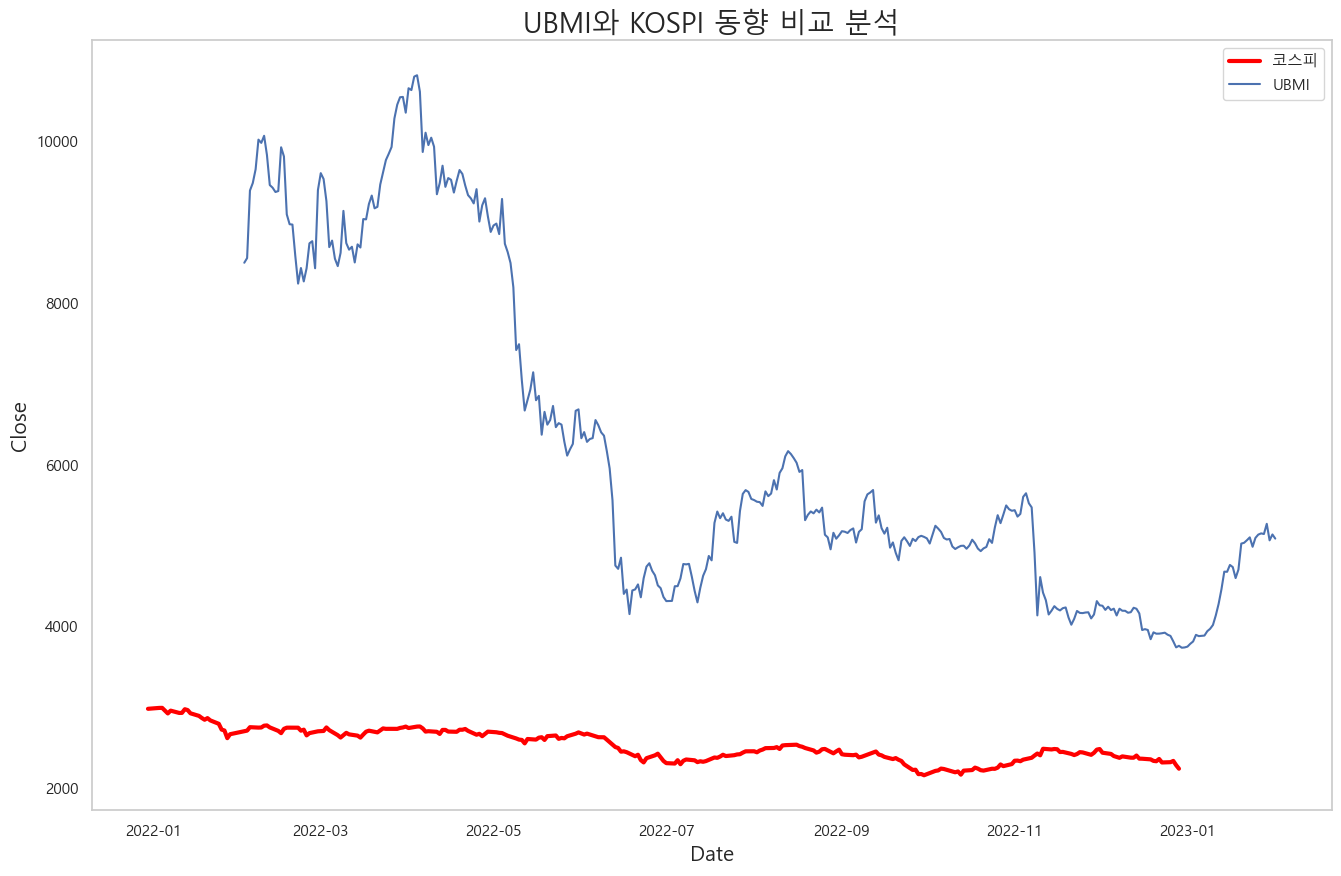

In [312]:
# Visualization: PER 하위 15개 종목과 코스피 보유수익률 비교

fig = plt.figure( figsize=(16, 10)) # 그래프 크기 조절

ax1 = sns.lineplot(
    data=kospi_short,
    x = 'Date',
    y = 'Close',
    label = '코스피',
    color = 'red',
    linewidth = 3
)

ax2 = sns.lineplot(
    data=ubmi,
    x = 'Date',
    y = 'Close',
    label = 'UBMI'
)

plt.legend(loc = 'best')
plt.ylabel('Close', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.grid()

plt.title('UBMI와 KOSPI 동향 비교 분석', fontsize=20)
plt.show()

In [330]:
kospi_short = kospi_short.reset_index(drop=True)
ubmi = ubmi.reset_index(drop=True)

In [394]:
scale_

Date  Close_x       Close_y  Normalization_x  Normalization_y
0   2022-02-03  2707.82   8555.335557         0.896000         0.680462
1   2022-02-04  2750.26   9390.772618         0.964847         0.798472
2   2022-02-07  2745.06  10020.746638         0.956411         0.887459
3   2022-02-08  2746.47   9980.597630         0.958698         0.881788
4   2022-02-09  2768.85  10068.494155         0.995004         0.894204
..         ...      ...           ...              ...              ...
221 2022-12-23  2313.69   3912.705430         0.256635         0.024664
222 2022-12-26  2317.14   3879.604595         0.262232         0.019988
223 2022-12-27  2332.79   3811.735029         0.287619         0.010401
224 2022-12-28  2280.45   3738.099302         0.202712         0.000000
225 2022-12-29  2236.40   3757.369741         0.131254         0.002722

[226 rows x 5 columns]

In [378]:
scale_ = pd.merge(kospi_short, ubmi, on='Date')
get_normalization(scale_.iloc[:,1:3])

array([[0.89599961, 0.68046161],
       [0.96484654, 0.79847178],
       [0.95641101, 0.88745914],
       [0.95869833, 0.88178787],
       [0.99500357, 0.89420374],
       [1.        , 0.86054979],
       [0.96070988, 0.80808667],
       [0.8905814 , 0.79758516],
       [0.84525663, 0.87411834],
       [0.93146129, 0.85810126],
       [0.95483745, 0.75680545],
       [0.95553501, 0.73961744],
       [0.95436701, 0.63584162],
       [0.89432873, 0.66309113],
       [0.91499578, 0.63961035],
       [0.80025631, 0.66275713],
       [0.84561352, 0.70620444],
       [0.88198365, 0.79933628],
       [0.88902407, 0.81862197],
       [0.95968789, 0.77993734],
       [0.90510025, 0.69960829],
       [0.80432808, 0.66639333],
       [0.75742976, 0.68960537],
       [0.85138862, 0.70669955],
       [0.82050159, 0.69515272],
       [0.79514632, 0.70439548],
       [0.75601843, 0.69889255],
       [0.81717604, 0.74861377],
       [0.87440789, 0.74810592],
       [0.89470184, 0.77495411],
       [0.

In [392]:
scale_['Normalization_x'] = np.array(get_normalization(scale_.iloc[:,1:3]))[:,0]
scale_['Normalization_y'] = np.array(get_normalization(scale_.iloc[:,1:3]))[:,1]

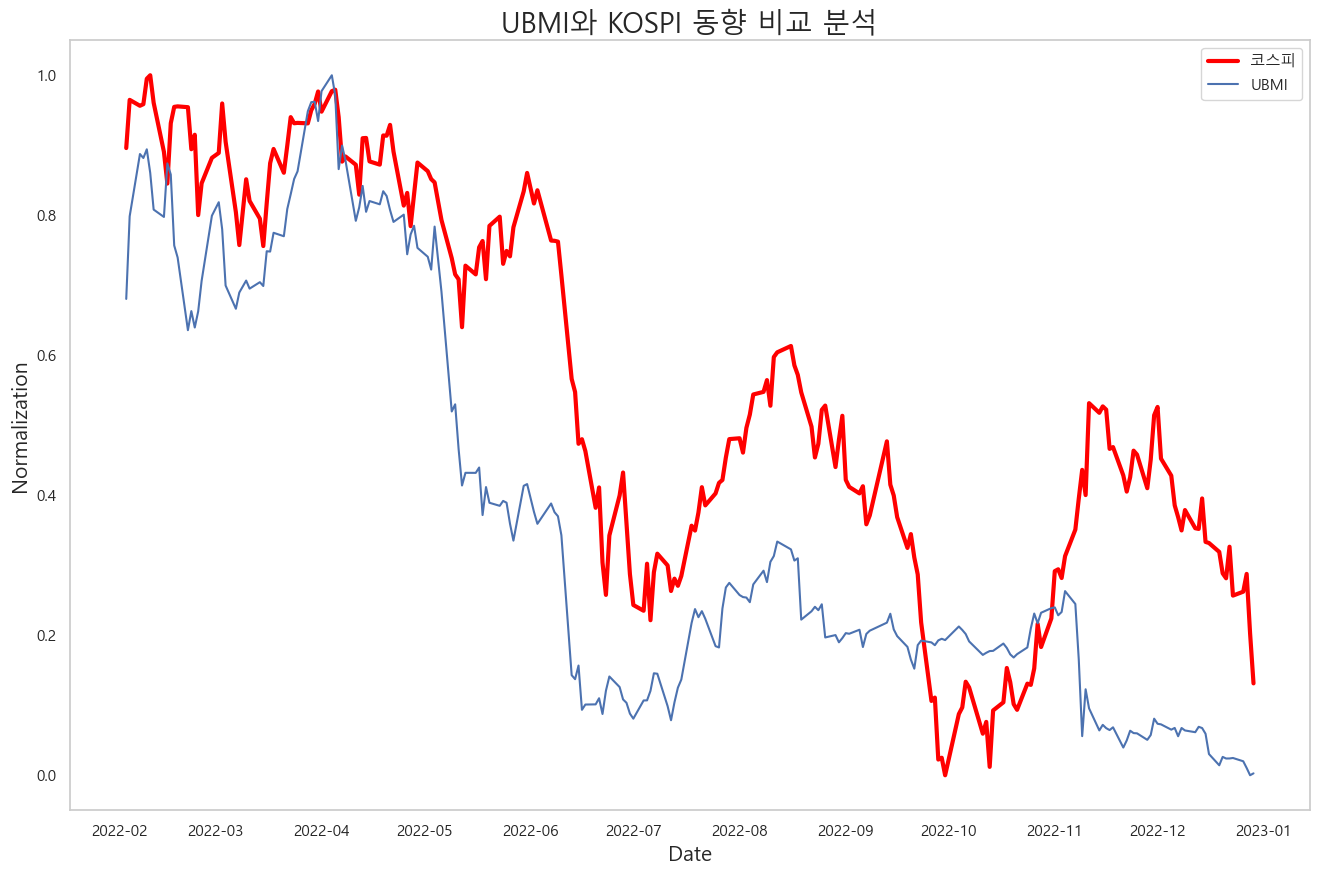

In [393]:
#Visualization: PER 하위 15개 종목과 코스피 보유수익률 비교

fig = plt.figure( figsize=(16, 10)) # 그래프 크기 조절

ax1 = sns.lineplot(
    data=scale_,
    x = 'Date',
    y = 'Normalization_x',
    label = '코스피',
    color = 'red',
    linewidth = 3
)

ax2 = sns.lineplot(
    data=scale_,
    x = 'Date',
    y = 'Normalization_y',
    label = 'UBMI'
)

plt.legend(loc = 'best')
plt.ylabel('Normalization', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.grid()

plt.title('UBMI와 KOSPI 동향 비교 분석', fontsize=20)
plt.show()

## 코스피 지수와 UBMI 지수 비교
- 처음에 코스피 지수와 UBMI 지수 값 자체로 비교해서 보려고 했지만 코스피 지수의 변동의 폭이 눈에 띄지 않아 정규화를 해서 그래프로 나타내보았다.
- 그 결과 약간의 유의미한 차이는 있지만 전체적으로 보았을 때 비슷한 움직임을 나타내는 것으로 판단된다.